## CSCI316 Group Assignment 2

### **Importing Libraries and Dataset**

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats
from scipy.stats import skew

In [2]:
import findspark
findspark.init()
import pyspark
from pyspark.sql import SparkSession
spark = SparkSession.builder.appName('CSCI316_Group1_A2')\
.config('spark-master', 'local')\
.getOrCreate()
from pyspark.sql.functions import col, lit

23/08/19 21:54:42 WARN Utils: Your hostname, angels-MacBook-Pro.local resolves to a loopback address: 127.0.0.1; using 192.168.1.100 instead (on interface en0)
23/08/19 21:54:42 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
23/08/19 21:54:42 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
Using Spark's default log4j profile: org/apache/spark/log4j-defaults.properties
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).


In [3]:
import seaborn as sns
from pyspark import SparkContext, SparkConf
from pyspark.ml import Pipeline
from pyspark.ml.linalg import DenseMatrix, Vectors
from pyspark.ml.stat import Correlation
from pyspark.mllib.stat import Statistics
from typing import List, Tuple, Dict
from pyspark.sql import Row, DataFrame
from pyspark.ml.classification import LogisticRegression, RandomForestClassifier, DecisionTreeClassifier
from pyspark.ml.feature import VectorAssembler, StringIndexer, StandardScaler
from pyspark.ml.evaluation import BinaryClassificationEvaluator, RegressionEvaluator, MulticlassClassificationEvaluator
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator
from pyspark.ml.regression import RandomForestRegressor
from sklearn.metrics import confusion_matrix

In [4]:
train_df = spark.read.csv('UNSW_NB15_training-set.csv', header = True, inferSchema=True)
train_df.show(5)

23/08/19 21:54:51 WARN package: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


+---+------+-----+-------+-----+-----+-----+------+------+-----------+----+----+------------+-----+-----+-----+------+------+----+----+----+-----+-----+----+------+------+------+-----+-----+-----------+-----------------+----------+------------+----------+----------------+----------------+--------------+------------+----------+----------------+----------+----------+---------------+----------+-----+
| id|   dur|proto|service|state|spkts|dpkts|sbytes|dbytes|       rate|sttl|dttl|       sload|dload|sloss|dloss|sinpkt|dinpkt|sjit|djit|swin|stcpb|dtcpb|dwin|tcprtt|synack|ackdat|smean|dmean|trans_depth|response_body_len|ct_srv_src|ct_state_ttl|ct_dst_ltm|ct_src_dport_ltm|ct_dst_sport_ltm|ct_dst_src_ltm|is_ftp_login|ct_ftp_cmd|ct_flw_http_mthd|ct_src_ltm|ct_srv_dst|is_sm_ips_ports|attack_cat|label|
+---+------+-----+-------+-----+-----+-----+------+------+-----------+----+----+------------+-----+-----+-----+------+------+----+----+----+-----+-----+----+------+------+------+-----+-----+--------

In [5]:
test_df = spark.read.csv('UNSW_NB15_testing-set.csv', header = True, inferSchema=True)
test_df.show(5)

+---+--------+-----+-------+-----+-----+-----+------+------+---------+----+----+-----------+-----------+-----+-----+----------+----------+-----------+-----------+----+----------+----------+----+--------+--------+--------+-----+-----+-----------+-----------------+----------+------------+----------+----------------+----------------+--------------+------------+----------+----------------+----------+----------+---------------+----------+-----+
| id|     dur|proto|service|state|spkts|dpkts|sbytes|dbytes|     rate|sttl|dttl|      sload|      dload|sloss|dloss|    sinpkt|    dinpkt|       sjit|       djit|swin|     stcpb|     dtcpb|dwin|  tcprtt|  synack|  ackdat|smean|dmean|trans_depth|response_body_len|ct_srv_src|ct_state_ttl|ct_dst_ltm|ct_src_dport_ltm|ct_dst_sport_ltm|ct_dst_src_ltm|is_ftp_login|ct_ftp_cmd|ct_flw_http_mthd|ct_src_ltm|ct_srv_dst|is_sm_ips_ports|attack_cat|label|
+---+--------+-----+-------+-----+-----+-----+------+------+---------+----+----+-----------+-----------+-----+--

In [6]:
# identify string columns
train_df.printSchema()

root
 |-- id: integer (nullable = true)
 |-- dur: double (nullable = true)
 |-- proto: string (nullable = true)
 |-- service: string (nullable = true)
 |-- state: string (nullable = true)
 |-- spkts: integer (nullable = true)
 |-- dpkts: integer (nullable = true)
 |-- sbytes: integer (nullable = true)
 |-- dbytes: integer (nullable = true)
 |-- rate: double (nullable = true)
 |-- sttl: integer (nullable = true)
 |-- dttl: integer (nullable = true)
 |-- sload: double (nullable = true)
 |-- dload: double (nullable = true)
 |-- sloss: integer (nullable = true)
 |-- dloss: integer (nullable = true)
 |-- sinpkt: double (nullable = true)
 |-- dinpkt: double (nullable = true)
 |-- sjit: double (nullable = true)
 |-- djit: double (nullable = true)
 |-- swin: integer (nullable = true)
 |-- stcpb: long (nullable = true)
 |-- dtcpb: long (nullable = true)
 |-- dwin: integer (nullable = true)
 |-- tcprtt: double (nullable = true)
 |-- synack: double (nullable = true)
 |-- ackdat: double (nullable 

In [7]:
# identify string columns
test_df.printSchema()

root
 |-- id: integer (nullable = true)
 |-- dur: double (nullable = true)
 |-- proto: string (nullable = true)
 |-- service: string (nullable = true)
 |-- state: string (nullable = true)
 |-- spkts: integer (nullable = true)
 |-- dpkts: integer (nullable = true)
 |-- sbytes: integer (nullable = true)
 |-- dbytes: integer (nullable = true)
 |-- rate: double (nullable = true)
 |-- sttl: integer (nullable = true)
 |-- dttl: integer (nullable = true)
 |-- sload: double (nullable = true)
 |-- dload: double (nullable = true)
 |-- sloss: integer (nullable = true)
 |-- dloss: integer (nullable = true)
 |-- sinpkt: double (nullable = true)
 |-- dinpkt: double (nullable = true)
 |-- sjit: double (nullable = true)
 |-- djit: double (nullable = true)
 |-- swin: integer (nullable = true)
 |-- stcpb: long (nullable = true)
 |-- dtcpb: long (nullable = true)
 |-- dwin: integer (nullable = true)
 |-- tcprtt: double (nullable = true)
 |-- synack: double (nullable = true)
 |-- ackdat: double (nullable 

### **(a) Discover and Visualise Data**

**Train DF**

**Visualization for count of "attack_cat" (Bar Graph)**

In [8]:
# identifying the types and number of records under 'attack_cat' column
pd_train_df = train_df.toPandas()
pd_train_df.groupby('attack_cat').size().sort_values(ascending=False)

attack_cat
Normal            37000
Generic           18871
Exploits          11132
Fuzzers            6062
DoS                4089
Reconnaissance     3496
Analysis            677
Backdoor            583
Shellcode           378
Worms                44
dtype: int64

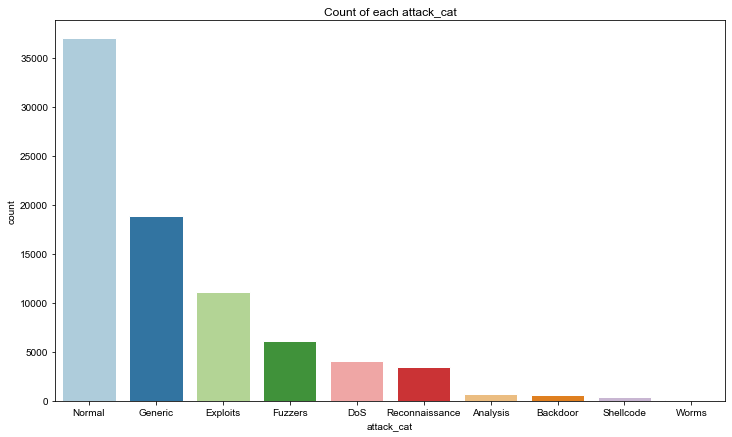

In [9]:
# visualize the count of each 'attack_cat' in data
plt.figure(figsize=(12,7))
plt.title('Count of each attack_cat')
sns.set_style('whitegrid')
sns.countplot(x=pd_train_df['attack_cat'],palette='Paired',order=pd_train_df['attack_cat'].value_counts().index)
plt.show()

**Visualization for count of "label" (Bar Graph)**

In [10]:
pd_train_df.groupby('label').size().sort_values(ascending=False)

label
1    45332
0    37000
dtype: int64

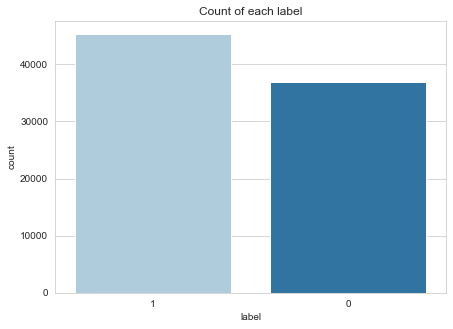

In [11]:
# visualize the count of each 'label' in data
plt.figure(figsize=(7,5))
plt.title('Count of each label')
sns.set_style('whitegrid')
sns.countplot(x=pd_train_df['label'],palette='Paired',order=pd_train_df['label'].value_counts().index)
plt.show()

**Visualization for percentage of each "label" (Pie Chart)**

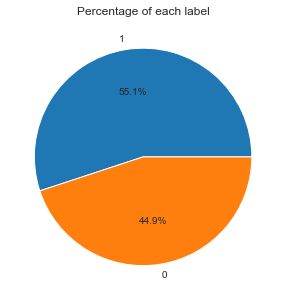

In [12]:
plt.figure(figsize=(5, 5))
pd_train_df['label'].value_counts().plot(kind='pie', autopct='%1.1f%%')
plt.ylabel('')
plt.title('Percentage of each label')
plt.show()

**Test DF**

**Visualization for count of "attack_cat" (Bar Graph)**

In [13]:
# identifying the types and number of records under 'attack_cat' column
pd_test_df = test_df.toPandas()
pd_test_df.groupby('attack_cat').size().sort_values(ascending=False)

attack_cat
Normal            56000
Generic           40000
Exploits          33393
Fuzzers           18184
DoS               12264
Reconnaissance    10491
Analysis           2000
Backdoor           1746
Shellcode          1133
Worms               130
dtype: int64

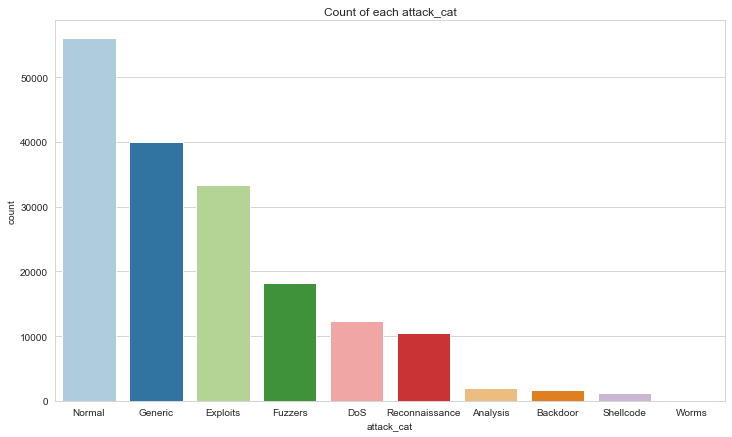

In [14]:
# visualize the count of each 'attack_cat' in data
plt.figure(figsize=(12,7))
plt.title('Count of each attack_cat')
sns.set_style('whitegrid')
sns.countplot(x=pd_test_df['attack_cat'],palette='Paired',order=pd_test_df['attack_cat'].value_counts().index)
plt.show()

**Visualization for count of "label" (Bar Graph)**

In [15]:
pd_test_df.groupby('label').size().sort_values(ascending=False)

label
1    119341
0     56000
dtype: int64

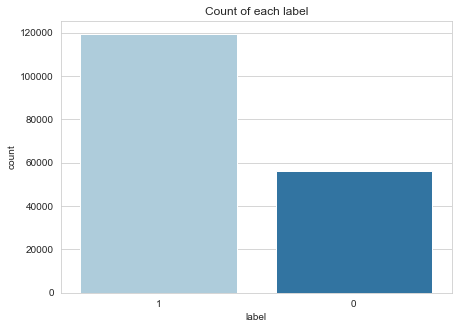

In [16]:
# visualize the count of each 'label' in data
plt.figure(figsize=(7,5))
plt.title('Count of each label')
sns.set_style('whitegrid')
sns.countplot(x=pd_test_df['label'],palette='Paired',order=pd_test_df['label'].value_counts().index)
plt.show()

**Visualization for percentage of each "label" (Pie Chart)**

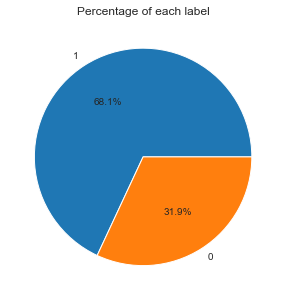

In [17]:
plt.figure(figsize=(5, 5))
pd_test_df['label'].value_counts().plot(kind='pie', autopct='%1.1f%%')
plt.ylabel('')
plt.title('Percentage of each label')
plt.show()

### **(b) Prepare the data for machine learning**

**Drop 'id' column**

In [18]:
# 'id' column is definitely redundant, so we drop it
train_df = train_df.drop('id')
test_df = test_df.drop('id')

**Converting categorical data into numerical data**

In [19]:
# function that takes a dataframe and a list of columns to index and returns a dataframe with indexed columns and the original columns dropped
def index_and_drop_columns(df, columns_to_index):
    indexed_df = df
    indexers = []

    for col_name in columns_to_index:
        indexer = StringIndexer(inputCol=col_name, outputCol=f"{col_name}_index")
        indexed_df = indexer.fit(indexed_df).transform(indexed_df)
        indexers.append(indexer)

    columns_to_drop = [col_name for col_name in columns_to_index]    
    indexed_df = indexed_df.drop(*columns_to_drop)
    
    return indexed_df

# apply the function to the train and test dataframes
columns_to_index = ["attack_cat", "proto", "service", "state"]
df_train_indexed = index_and_drop_columns(train_df, columns_to_index)
df_test_indexed = index_and_drop_columns(test_df, columns_to_index)

In [20]:
df_train_indexed.show()

+------+-----+-----+------+------+-----------+----+----+-------------+-----+-----+-----+---------+------+----+----+----+-----+-----+----+------+------+------+-----+-----+-----------+-----------------+----------+------------+----------+----------------+----------------+--------------+------------+----------+----------------+----------+----------+---------------+-----+----------------+-----------+-------------+-----------+
|   dur|spkts|dpkts|sbytes|dbytes|       rate|sttl|dttl|        sload|dload|sloss|dloss|   sinpkt|dinpkt|sjit|djit|swin|stcpb|dtcpb|dwin|tcprtt|synack|ackdat|smean|dmean|trans_depth|response_body_len|ct_srv_src|ct_state_ttl|ct_dst_ltm|ct_src_dport_ltm|ct_dst_sport_ltm|ct_dst_src_ltm|is_ftp_login|ct_ftp_cmd|ct_flw_http_mthd|ct_src_ltm|ct_srv_dst|is_sm_ips_ports|label|attack_cat_index|proto_index|service_index|state_index|
+------+-----+-----+------+------+-----------+----+----+-------------+-----+-----+-----+---------+------+----+----+----+-----+-----+----+------+------

In [21]:
df_test_indexed.show()

+--------+-----+-----+------+------+-----------+----+----+-----------+-----------+-----+-----+----------+----------+-----------+-----------+----+----------+----------+----+--------+--------+--------+-----+-----+-----------+-----------------+----------+------------+----------+----------------+----------------+--------------+------------+----------+----------------+----------+----------+---------------+-----+----------------+-----------+-------------+-----------+
|     dur|spkts|dpkts|sbytes|dbytes|       rate|sttl|dttl|      sload|      dload|sloss|dloss|    sinpkt|    dinpkt|       sjit|       djit|swin|     stcpb|     dtcpb|dwin|  tcprtt|  synack|  ackdat|smean|dmean|trans_depth|response_body_len|ct_srv_src|ct_state_ttl|ct_dst_ltm|ct_src_dport_ltm|ct_dst_sport_ltm|ct_dst_src_ltm|is_ftp_login|ct_ftp_cmd|ct_flw_http_mthd|ct_src_ltm|ct_srv_dst|is_sm_ips_ports|label|attack_cat_index|proto_index|service_index|state_index|
+--------+-----+-----+------+------+-----------+----+----+----------

In [22]:
df_train_indexed = df_train_indexed.toPandas()
df_test_indexed = df_test_indexed.toPandas()

In [23]:
df_train_indexed.head()

,dur,spkts,dpkts,sbytes,dbytes,rate,sttl,dttl,sload,dload,...,ct_ftp_cmd,ct_flw_http_mthd,ct_src_ltm,ct_srv_dst,is_sm_ips_ports,label,attack_cat_index,proto_index,service_index,state_index
0,0.000011,2,0,496,0,90909.0902,254,0,180363632.0,0.0,...,0,0,1,2,0,0,0.0,1.0,0.0,1.0
1,0.000008,2,0,1762,0,125000.0003,254,0,881000000.0,0.0,...,0,0,1,2,0,0,0.0,1.0,0.0,1.0
2,0.000005,2,0,1068,0,200000.0051,254,0,854400000.0,0.0,...,0,0,1,3,0,0,0.0,1.0,0.0,1.0
3,0.000006,2,0,900,0,166666.6608,254,0,600000000.0,0.0,...,0,0,2,3,0,0,0.0,1.0,0.0,1.0
4,0.000010,2,0,2126,0,100000.0025,254,0,850400000.0,0.0,...,0,0,2,3,0,0,0.0,1.0,0.0,1.0


In [24]:
df_test_indexed.head()

,dur,spkts,dpkts,sbytes,dbytes,rate,sttl,dttl,sload,dload,...,ct_ftp_cmd,ct_flw_http_mthd,ct_src_ltm,ct_srv_dst,is_sm_ips_ports,label,attack_cat_index,proto_index,service_index,state_index
0,0.121478,6,4,258,172,74.087490,252,254,14158.942380,8495.365234,...,0,0,1,1,0,0,0.0,0.0,0.0,1.0
1,0.649902,14,38,734,42014,78.473372,62,252,8395.112305,503571.312500,...,0,0,1,6,0,0,0.0,0.0,0.0,1.0
2,1.623129,8,16,364,13186,14.170161,62,252,1572.271851,60929.230470,...,0,0,2,6,0,0,0.0,0.0,0.0,1.0
3,1.681642,12,12,628,770,13.677108,62,252,2740.178955,3358.622070,...,1,0,2,1,0,0,0.0,0.0,5.0,1.0
4,0.449454,10,6,534,268,33.373826,254,252,8561.499023,3987.059814,...,0,0,2,39,0,0,0.0,0.0,0.0,1.0


In [25]:
# to check the number of unique values corresponds to the original column
print("attack_cat_index:", df_train_indexed['attack_cat_index'].unique())
print("attack_cat_index:", df_test_indexed['attack_cat_index'].unique())

print("\nproto_index:", df_train_indexed['proto_index'].unique())
print("proto_index:", df_test_indexed['proto_index'].unique())

print("\nservice_index:", df_train_indexed['service_index'].unique())
print("service_index:", df_test_indexed['service_index'].unique())

print("\nstate_index:", df_train_indexed['state_index'].unique())
print("state_index:", df_test_indexed['state_index'].unique())

attack_cat_index: [0. 5. 7. 4. 2. 6. 3. 9. 8. 1.]
attack_cat_index: [0. 7. 6. 3. 8. 5. 2. 4. 9. 1.]

proto_index: [  1.   3.   0. 130.   4.   5.   7.  25.  28.  29.  38.  19.  21.  23.
  24.  35.  36.  41.  33.  22.  26.  17.  39.  40.  18.  16.  32.  30.
  37.  34.  87.  86.  42.  66.  55.  67. 117.   9. 105.  76.  79.  68.
  88.  64. 100.  12.  91. 107. 116.  77.   6.  78.  49. 101.  75.  83.
 102.  52. 126.  98.  48.  11. 125. 122. 118. 120.  92.  57.  58. 115.
 111.  85.  90.  46.  73.  44.  89.  59.  96.  63.  69.  95.  99. 104.
  20.  15.  27.  47.  14. 121.  72.  51.  31. 124.  10. 106. 127.  70.
   8.   2.  61.  82.  60.  13.  45.  43.  71. 110.  50.  80.  93. 123.
  84. 128.  56.  65. 114. 113. 119. 108. 109.  81.  97.  62.  53.  54.
 103.  74.  94. 112. 129.]
proto_index: [  0.   1.   3.   4. 131. 130. 132.  28.  49.  23.  99.  71.  97.  63.
  69.  75.  25.  11.  55. 100.  43.   2.  60.  16.  52.  41.  21.  12.
  56.  26.  13.  98.  95.  15.  30.  31.  20.  36.  68.  14.  66.

**Checking correlation and selecting top 10 columns**

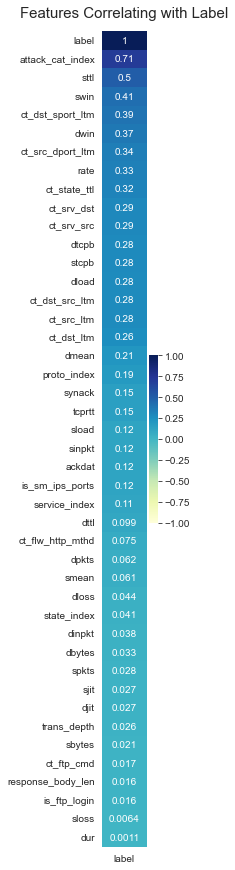

In [26]:
# Visualize the correlation of all columns
plt.figure(figsize=(1,15))
heatmap = sns.heatmap(df_train_indexed.corr()[['label']].abs().sort_values #abs() to get absolute value regardless of negative correlation
                     (by='label', ascending=False), vmin=-1,
                      vmax=1, annot=True, cmap='YlGnBu')

heatmap.set_title('Features Correlating with Label',
                  fontdict={'fontsize':15}, pad=14)

plt.show()

In [27]:
# 10 selected columns (highest correlation to label)
df10_train = pd.DataFrame(df_train_indexed,columns=['sttl', 'swin', 'ct_dst_sport_ltm', 'dwin', 
                                                    'ct_src_dport_ltm', 'rate', 'ct_state_ttl', 
                                                    'ct_srv_dst', 'ct_srv_src', 'dtcpb', 'label'])

df10_test = pd.DataFrame(df_train_indexed,columns=['sttl', 'swin', 'ct_dst_sport_ltm', 'dwin', 
                                                    'ct_src_dport_ltm', 'rate', 'ct_state_ttl', 
                                                    'ct_srv_dst', 'ct_srv_src', 'dtcpb', 'label'])

# return correlation matrix of df20
corr = df10_train.corr()
corr = corr['label'].abs().sort_values()
corr

dtcpb               0.282860
ct_srv_src          0.290195
ct_srv_dst          0.292931
ct_state_ttl        0.318517
rate                0.328629
ct_src_dport_ltm    0.341513
dwin                0.369257
ct_dst_sport_ltm    0.393668
swin                0.414504
sttl                0.504159
label               1.000000
Name: label, dtype: float64

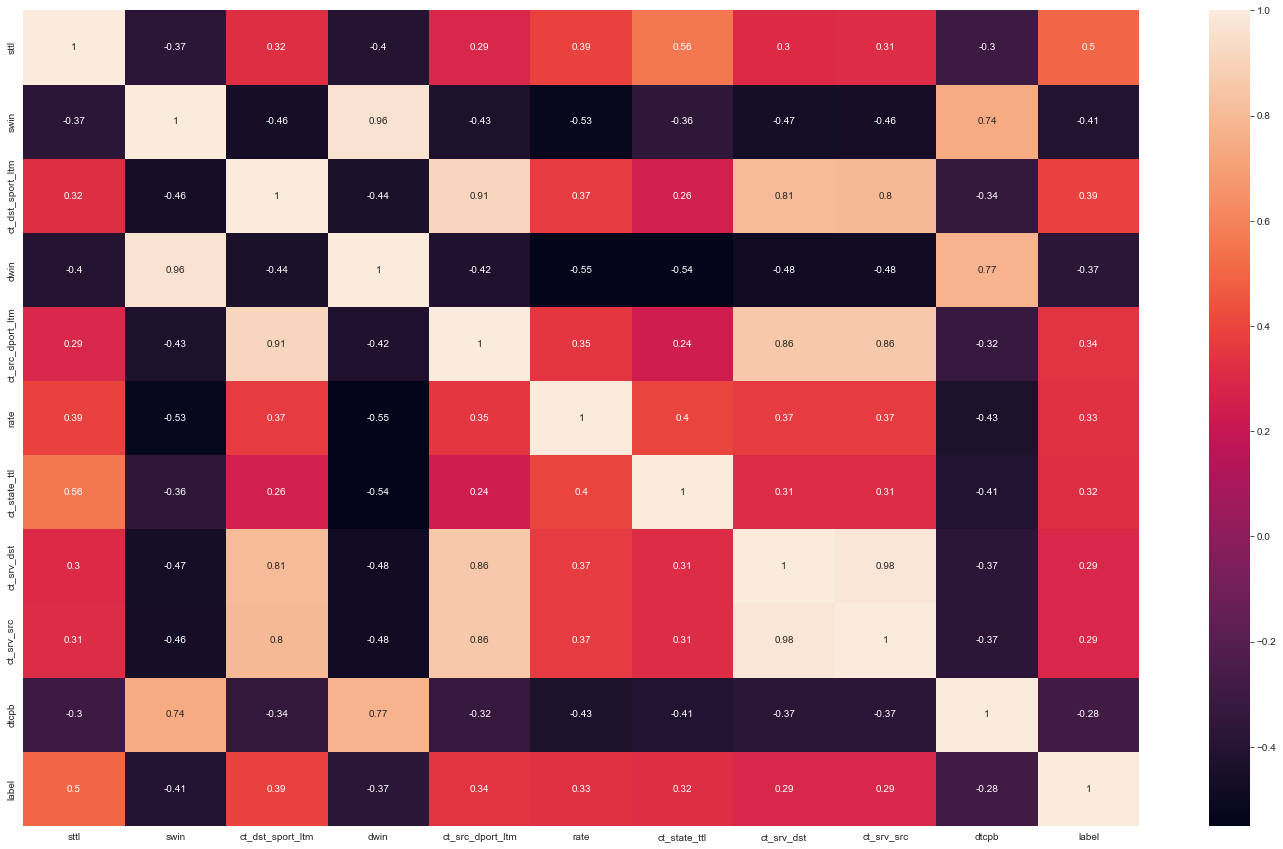

In [28]:
# visualize the correlation of all columns in df2
plt.figure(figsize=(25,15))

# using heapmap to plot
sns.heatmap(round(df10_train.corr(), 2), annot=True)

# show the plot
plt.show()

**Z-Score Normalization**

In [29]:
# convert from pandas to spark for normalization
df10_train_py = spark.createDataFrame(df10_train)
df10_test_py = spark.createDataFrame(df10_test)

# function for z-score normalization
def z_score_normalize(dataset: DataFrame, feature_columns: list) -> DataFrame:
    # assemble features into a vector column
    assembler = VectorAssembler(inputCols=feature_columns, outputCol="features")
    df_with_features = assembler.transform(dataset)

    # z-score normalization using StandardScaler
    z_scaler = StandardScaler(inputCol="features", outputCol="z_scaled_features", withMean=True, withStd=True)
    z_scaler_model = z_scaler.fit(df_with_features)
    z_normalized_df = z_scaler_model.transform(df_with_features)
    
    return z_normalized_df

# all columns except 'label'
feature_columns = ['sttl', 'swin', 'ct_dst_sport_ltm', 
                   'dwin', 'ct_src_dport_ltm', 'rate', 'ct_state_ttl', 
                   'ct_srv_dst', 'ct_srv_src', 'dtcpb']
train_data = z_score_normalize(df10_train_py, feature_columns)
test_data = z_score_normalize(df10_test_py, feature_columns)

In [30]:
train_data.select("features", "z_scaled_features").show(truncate=False)

+---------------------------------------------------+----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|features                                           |z_scaled_features                                                                                                                                                                                         |
+---------------------------------------------------+----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|[254.0,0.0,1.0,0.0,1.0,90909.0902,2.0,2.0,2.0,0.0] |[0.7194356910787414,-1.0479131934078003,-0.4501837608631865,-1.0062376768714802,-0.4683087717050059,0.05718061144722471,0.5910174773111673,-0.6441862671743399,-0.68046958047577

In [31]:
test_data.select("features", "z_scaled_features").show(truncate=False)

+---------------------------------------------------+----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|features                                           |z_scaled_features                                                                                                                                                                                         |
+---------------------------------------------------+----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|[254.0,0.0,1.0,0.0,1.0,90909.0902,2.0,2.0,2.0,0.0] |[0.7194356910787414,-1.0479131934078003,-0.4501837608631865,-1.0062376768714802,-0.4683087717050059,0.05718061144722471,0.5910174773111673,-0.6441862671743399,-0.68046958047577

### **(c) Select and train models**

### Logistic Regression

In [32]:
# train logistic regression model
lr = LogisticRegression(featuresCol="z_scaled_features", labelCol="label")
lr_model = lr.fit(train_data)

# evaluate the model on the training data
train_results = lr_model.transform(train_data)

# evaluate the model on the testing data
test_results = lr_model.transform(test_data)

# calculate ROC AUC for training and testing data
evaluator = BinaryClassificationEvaluator(rawPredictionCol="rawPrediction")
train_roc_auc = evaluator.evaluate(train_results)
test_roc_auc = evaluator.evaluate(test_results)

print("Train ROC AUC:", train_roc_auc)
print("Test ROC AUC:", test_roc_auc)

23/08/19 21:55:29 WARN BLAS: Failed to load implementation from: com.github.fommil.netlib.NativeSystemBLAS
23/08/19 21:55:29 WARN BLAS: Failed to load implementation from: com.github.fommil.netlib.NativeRefBLAS


Train ROC AUC: 0.8839283567958677
Test ROC AUC: 0.8839339452948933


Fine-tuning

In [33]:
lr = LogisticRegression(featuresCol="z_scaled_features", labelCol="label")

paramGrid = (ParamGridBuilder()
             .addGrid(lr.regParam, [0, 1.0, 0.1, 0.01, 0.001])
             .addGrid(lr.threshold, [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7])
             .addGrid(lr.maxIter, [10, 50, 100, 200])
             .build())

# setup cross-validation for hyperparameter search
crossval = CrossValidator(estimator=lr,
                          estimatorParamMaps=paramGrid,
                          evaluator=BinaryClassificationEvaluator(),
                          numFolds=5)

# run cross-validation to find the best hyperparameters
cv_model = crossval.fit(train_data)

# get the best model with the best hyperparameters
best_lr_model = cv_model.bestModel

# evaluate the best model on the test data
test_results = best_lr_model.transform(test_data)

# calculate ROC AUC for the best model
evaluator = BinaryClassificationEvaluator(rawPredictionCol="rawPrediction")
roc_auc = evaluator.evaluate(test_results)
print("Best Model ROC AUC:", roc_auc)

# Retrieve the best hyperparameters
best_reg_param = best_lr_model._java_obj.getRegParam()
best_threshold = best_lr_model._java_obj.getThreshold()
best_max_iter = best_lr_model._java_obj.getMaxIter()
print("Best Regularization Parameter:", best_reg_param)
print("Best Threshold:", best_threshold)
print("Best Max Iterations:", best_max_iter)

Best Model ROC AUC: 0.8902171665621326
Best Regularization Parameter: 0.001
Best Threshold: 0.4
Best Max Iterations: 200


### Random Forest

In [34]:
rf = RandomForestClassifier(labelCol="label", featuresCol="z_scaled_features")
# train the Random Forest model
rf_model = rf.fit(train_data)

evaluator = BinaryClassificationEvaluator(rawPredictionCol="rawPrediction")

# Evaluate the model on the test data
train_results = rf_model.transform(train_data)
test_results = rf_model.transform(test_data)
train_roc_auc = evaluator.evaluate(train_results)
test_roc_auc = evaluator.evaluate(test_results)

print("Train ROC AUC:", train_roc_auc)
print("Test ROC AUC:", test_roc_auc)

Train ROC AUC: 0.9578013270263114
Test ROC AUC: 0.9578013270263114


Fine tuning

In [35]:
# Define the Random Forest model
rf_model = RandomForestClassifier(labelCol="label", featuresCol="z_scaled_features")

# Define the parameter grid for tuning
param_grid = (ParamGridBuilder()
    .addGrid(rf_model.numTrees, [50, 100, 150])
    .addGrid(rf_model.maxDepth, [5, 10])
    .addGrid(rf_model.minInstancesPerNode, [1, 5, 10])
    .build())

# Define the evaluator
evaluator = BinaryClassificationEvaluator(labelCol="label")

# Create a CrossValidator
cross_validator = CrossValidator(estimator=rf_model,
                                 estimatorParamMaps=param_grid,
                                 evaluator=evaluator,
                                 numFolds=3)

# Perform cross-validation and choose the best model
cross_validator_model = cross_validator.fit(train_data)
best_rf_model = cross_validator_model.bestModel

# Evaluate the best model on the test data
test_results = best_rf_model.transform(test_data)
roc_auc = evaluator.evaluate(test_results)

print("Best Model ROC AUC:", roc_auc)

# Retrieve the best hyperparameters
best_num_trees = best_rf_model._java_obj.getNumTrees()
best_max_depth = best_rf_model._java_obj.getMaxDepth()
best_min_instances_per_node = best_rf_model._java_obj.getMinInstancesPerNode()
print("Best Number of Trees:", best_num_trees)
print("Best Max Depth:", best_max_depth)
print("Best Min Instances Per Node:", best_min_instances_per_node)

23/08/19 22:17:55 WARN DAGScheduler: Broadcasting large task binary with size 1181.7 KiB
23/08/19 22:17:56 WARN DAGScheduler: Broadcasting large task binary with size 1708.5 KiB
23/08/19 22:17:57 WARN DAGScheduler: Broadcasting large task binary with size 1044.7 KiB
23/08/19 22:18:00 WARN DAGScheduler: Broadcasting large task binary with size 1182.8 KiB
23/08/19 22:18:01 WARN DAGScheduler: Broadcasting large task binary with size 1669.6 KiB
23/08/19 22:18:05 WARN DAGScheduler: Broadcasting large task binary with size 1141.1 KiB
23/08/19 22:18:06 WARN DAGScheduler: Broadcasting large task binary with size 1579.6 KiB
23/08/19 22:18:20 WARN DAGScheduler: Broadcasting large task binary with size 1539.7 KiB
23/08/19 22:18:22 WARN DAGScheduler: Broadcasting large task binary with size 2.3 MiB
23/08/19 22:18:24 WARN DAGScheduler: Broadcasting large task binary with size 3.4 MiB
23/08/19 22:18:26 WARN DAGScheduler: Broadcasting large task binary with size 2.0 MiB
23/08/19 22:18:31 WARN DAGSche

Best Model ROC AUC: 0.9713663717653063
Best Number of Trees: 150
Best Max Depth: 10
Best Min Instances Per Node: 1


### Decision Tree Classifier

In [36]:
dtc = DecisionTreeClassifier(featuresCol="z_scaled_features", labelCol="label", maxBins=150)
dtc = dtc.fit(train_data)

df_predictions_train = dtc.transform(train_data)

df_predictions_test = dtc.transform(test_data)  

evaluator = BinaryClassificationEvaluator(rawPredictionCol="rawPrediction")

# Evaluate the model on the test data
train_results = dtc.transform(train_data)
test_results = dtc.transform(test_data)
train_roc_auc = evaluator.evaluate(train_results)
test_roc_auc = evaluator.evaluate(test_results)


print("Train ROC AUC:", train_roc_auc)
print("Test ROC AUC:", test_roc_auc)

Train ROC AUC: 0.8955363218155066
Test ROC AUC: 0.8955363218155066


Fine-Tuning

In [37]:
train_accuracy = 0
best_accuracy = 0
best_maxDepth = 0
best_maxBins = 0

for maxDepth in [5,10]:
    for maxBins in [200, 400]:
        dtc2 = DecisionTreeClassifier(featuresCol="z_scaled_features", labelCol="label", maxDepth=maxDepth, maxBins=maxBins)
        dtc2 = dtc2.fit(train_data)
        df_predictions_train  = dtc2.transform(train_data)
        df_predictions = dtc2.transform(test_data)
        df_accuracy_test = MulticlassClassificationEvaluator(labelCol="label", metricName = "accuracy").evaluate(df_predictions)
        df_accuracy_train = MulticlassClassificationEvaluator(labelCol="label", metricName = "accuracy").evaluate(df_predictions_train)

        if df_accuracy_test*100 > best_accuracy:
            best_accuracy = df_accuracy_test*100
            train_accuracy = df_accuracy_train*100
            best_maxDepth = maxDepth
            best_maxBins = maxBins
            

print(f"Best Model ROC AUC: {best_accuracy}")
print(f"Best Max Depth: {best_maxDepth}")
print(f"Best Max Bins: {best_maxBins}")

Best Model ROC AUC: 90.27717048049361
Best Max Depth: 10
Best Max Bins: 400


# Comparison of the 3 models

Model: Logistic Regression
Pre-finetuning accuracy:
Post-finetuning accuracy: 


Model: Random Forest 
Pre-finetuning accuracy:
Post-finetuning accuracy: 


Model: Decision Tree Classifier
Pre-finetuning accuracy:
Post-finetuning accuracy: 

# comparison between Spark MLlib and Scikit-Learn

* Spark MLlib scales better with larger datasets as it takes lesser time to process compared to Scikit-Learn. However, if the dataset is small, it would be better to use Scikit-Learn as SPARK is slower for datasets that are smaller in size.

* Scikit_Learn is generally more beginner friendly and better suited for new users as it is easier to visualise data due to access to tools like MatPlotLib and Pandas, while also having a a straightforward and user-friendly API.

* When dealing with large datasets or when professional and industry level implementation is required, Spark tends to be the better choice due to access to Apache Spark allowing and its big data analysis tools

* from our experience, using Spark was relatively faster than using Scikit-Learn for our machine learning, but the visualisation of data was cleaner when we used Scikit-Learn for our first assignment.

* All in all, which library to use depends on the nature of dataset as well as other factors such as experience level of the user and whether or not visualisation of the data is important. For new users, it is advisable to play around with Scikit-Learn to break into this field.